In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os
import sys
import importlib
import numpy as np
import xarray as xr
import basin_masks
import streamfunction
import matplotlib.pyplot as plt

from functools import reduce

user_home_dir = os.getcwd()
sys.path.append(os.path.join(user_home_dir, "ECCOv4-py"))

import ecco_v4_py as ecco

In [2]:
importlib.reload(streamfunction)

<module 'streamfunction' from 'C:\\Users\\aline\\OTP\\streamfunction.py'>

In [3]:
# Change this to your local Drive dir
DIR = "H:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/"
DATA_DIR = DIR + "GTC/solodoch_data_full/ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4"

In [4]:
## Load ECCO variables
nc_files = (os.path.join(DATA_DIR, '*.nc'))
ds = xr.open_mfdataset(nc_files, data_vars='minimal',coords='minimal',compat='override')

geom_fp = 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc'

ECCO_dir = os.path.join(user_home_dir,geom_fp)
ecco_grid = xr.open_dataset(ECCO_dir)
ds = xr.merge((ds, ecco_grid))
ds

<xarray.Dataset>
Dimensions:    (tile: 13, j_g: 90, i_g: 90, k_p1: 51, k_l: 50, j: 90, i: 90,
                time: 312, k: 50, nb: 4, k_u: 50, nv: 2)
Coordinates: (12/24)
    XG         (tile, j_g, i_g) float32 -115.0 -115.0 -115.0 ... -102.9 -109.0
    Zp1        (k_p1) float32 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zl         (k_l) float32 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    YC         (tile, j, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
    XC         (tile, j, i) float32 -111.6 -111.3 -110.9 ... -105.6 -111.9
    YG         (tile, j_g, i_g) float32 -88.18 -88.32 -88.46 ... -87.99 -88.02
    ...         ...
  * k_p1       (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * nb         (nb) float32 0.0 1.0 2.0 3.0
  * nv         (nv) float32 0.0 1.0
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables: (12/24)
    VVELMASS   (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 1, 13, 90, 90), meta=np.ndarray>
    WVELMASS   (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 1, 13, 90, 90), meta=np.ndarray>
    UVELMASS   (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 1, 13, 90, 90), meta=np.ndarray>
    CS         (tile, j, i) float32 ...
    SN         (tile, j, i) float32 ...
    rA         (tile, j, i) float32 ...
    ...         ...
    hFacC      (k, tile, j, i) float32 ...
    hFacW      (k, tile, j, i_g) float32 ...
    hFacS      (k, tile, j_g, i) float32 ...
    maskC      (k, tile, j, i) bool ...
    maskW      (k, tile, j, i_g) bool ...
    maskS      (k, tile, j_g, i) bool ...
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Three-Dimensional Volume Flux...
    uuid:                            54fde4fa-4181-11eb-807f-0cc47a3f8057
    history_json:                    [{"$schema":"https:\/\/harmony.earthdata...

In [5]:
basin_masks.get_available_basin_names_solodoch()

['atlantic', 'indo-pacific', 'southern']

In [53]:
# Loop over the basins and their respective latitudes
basin = 'southern'
latitudes = basin_masks.get_lats_of_interest_solodoch(basin)
print(latitudes)

latitude = latitudes[0]
longitudes = basin_masks.get_longitudes_at_latitude(latitude, basin, geom_fp)
longitude_sections = np.split(longitudes, np.where(np.diff(longitudes) > 1)[0] + 1)
print(longitude_sections)

[-55, -60]
get_basin_name:  ['pac', 'atl', 'ind', 'arct', 'bering', 'southChina', 'mexico', 'okhotsk', 'hudson', 'med', 'java', 'north', 'japan', 'timor', 'eastChina', 'red', 'gulf', 'baffin', 'gin', 'barents'] C:\Users\aline\OTP\ECCOv4-py\binary_data
load_binary_array: loading file C:\Users\aline\OTP\ECCOv4-py\binary_data\basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
[array([-179.5, -178.5, -177.5, -176.5, -175.5, -174.5, -173.5, -172.5,
       -171.5, -170.5, -169.5, -168.5, -167.5, -166.5, -165.5, -164.5,
       -163.5, -162.5, -161.5, -160.5, -159.5, -158.5, -157.5, -156.5,
       -155.5, -154.5, -153.5, -152.5, -151.5, -150.5, -149.5, -148.5,
       -147.5, -146.5, -145.5, -144.5, -143.5, -142.5, -141.5, -1

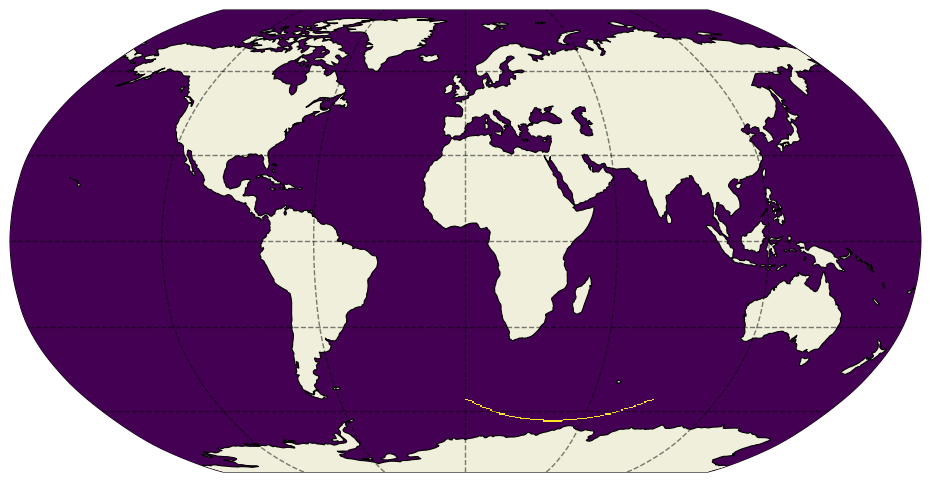

In [59]:
# Get the mask for the current section (merge subsections if needed)
masks_W = []
masks_S = [] 
masks_C = []

for section in longitude_sections:
    maskC, maskW, maskS = ecco.get_section_line_masks([0, latitude],[90, latitude], ds)
    masks_C.append(maskC)
    masks_W.append(maskW)
    masks_S.append(maskS)
    
maskC_tot = reduce(lambda x, y: x | y, masks_C)
maskS_tot = reduce(lambda x, y: x | y, masks_S)
maskW_tot = reduce(lambda x, y: x | y, masks_W)

plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,maskC_tot,cmap='viridis',projection_type='robin',user_lon_0=0);

In [63]:
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

In [46]:
# ALTERNATIVE WAY OF LOADING A MASK FOR A FULL LATITUDE
latitude = -60
grid = ecco.ecco_utils.get_llc_grid(ds)
coords = parse_coords(ds, None, ["Z", "YC", "drF", "dyG", "dxG"])
lat_maskW, lat_maskS = ecco.vector_calc.get_latitude_masks(latitude, coords["YC"], grid=grid)

In [65]:
# HOW THE CALCULATION WORKED THROUGH ECCO

%%time
PSI = ecco.calc_section_stf(
    ds, maskW= maskW, maskS= maskS, section_name=f"{format_lat_lon(latitude)}", zonal_average=False).compute()
OUTPUT_DIR = os.path.join(DIR, "GTC/streamfunctions_ecco")
PSI.to_netcdf(os.path.join(OUTPUT_DIR, f'{format_lat_lon(latitude)}', f'PSI_test_x_{format_lat_lon(latitude)}.nc'))

CPU times: total: 41.5 s
Wall time: 1min 31s


In [64]:
def parse_coords(ds, coords, coordlist):
    if coords is not None:
        return coords
    else:
        for f in set(["maskW", "maskS"]).intersection(ds.reset_coords().keys()):
            coordlist.append(f)

        if "time" in ds.dims:
            coordlist.append("time")

        dsout = ds[coordlist]
        if "domain" in ds.attrs:
            dsout.attrs["domain"] = ds.attrs["domain"]
        return dsout

In [82]:
def _initialize_section_trsp_data_array(coords):
    xda = xr.zeros_like(coords["k"])
    xda = (
        xda if "time" not in coords.dims else xda.broadcast_like(coords["time"]).copy()
    )

    # Convert to dataset to add Z coordinate
    xds = xda.to_dataset(name="trsp_z")
    xds["Z"] = coords["Z"]
    xds = xds.set_coords("Z")

    return xds

In [101]:
# Setup the grid system and multiply the values with the grid cell width and height
coords = parse_coords(ds, None, ["Z", "XC", "YC", "drF", "dyG", "dxG"])
y_vol = ds["VVELMASS"] * coords["drF"] * coords["dxG"]

In [87]:
# Initialize data output
coords = coords if coords is not None else y_vol.to_dataset(name="yfld")
ds_out = _initialize_section_trsp_data_array(coords)

In [89]:
# Check where the mask exactly is in terms of the grid
maskW2 = maskW.where(coords["maskW"]) if "maskW" in coords else maskW
maskS2 = maskS.where(coords["maskS"]) if "maskS" in coords else maskS

In [94]:
# Calculate the meridional transport 
sec_trsp_y = (y_vol*maskS2).sum(dim=["i", "j_g", "tile"])
ds_out["trsp_z"] = sec_trsp_y

In [95]:
# Convert to sverdrups and calculate the cumulative sum over depth
METERS_CUBED_TO_SVERDRUPS = 10**-6

psi_moc = ds_out["trsp_z"].copy(deep=True)
psi_moc = psi_moc.isel(k=slice(None, None, -1))

psi_moc = psi_moc.cumsum(dim="k")
psi_moc = -1 * psi_moc.isel(k=slice(None, None, -1))
ds_out["psi_moc"] = psi_moc

ds_out["moc"] = ds_out["psi_moc"].max(dim="k")

for fld in ["trsp_z", "psi_moc", "moc"]:
    ds_out[fld] = ds_out[fld] * METERS_CUBED_TO_SVERDRUPS
    ds_out[fld].attrs["units"] = "Sv"

In [98]:
ds_out

<xarray.Dataset>
Dimensions:  (k: 50, time: 312)
Coordinates:
    Z        (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    trsp_z   (time, k) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    psi_moc  (time, k) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    moc      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

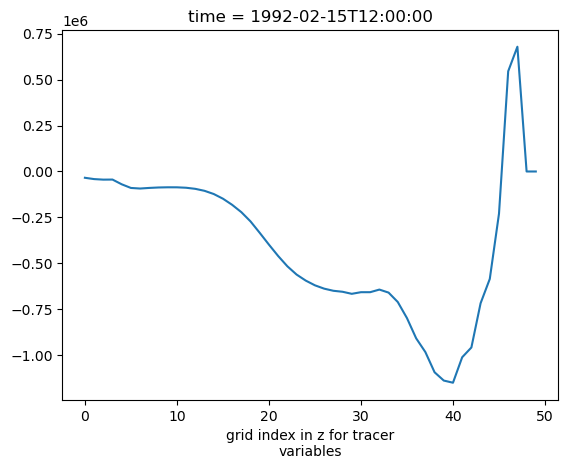

In [96]:
sec_trsp_y.isel(time=1).plot()

KeyboardInterrupt: 

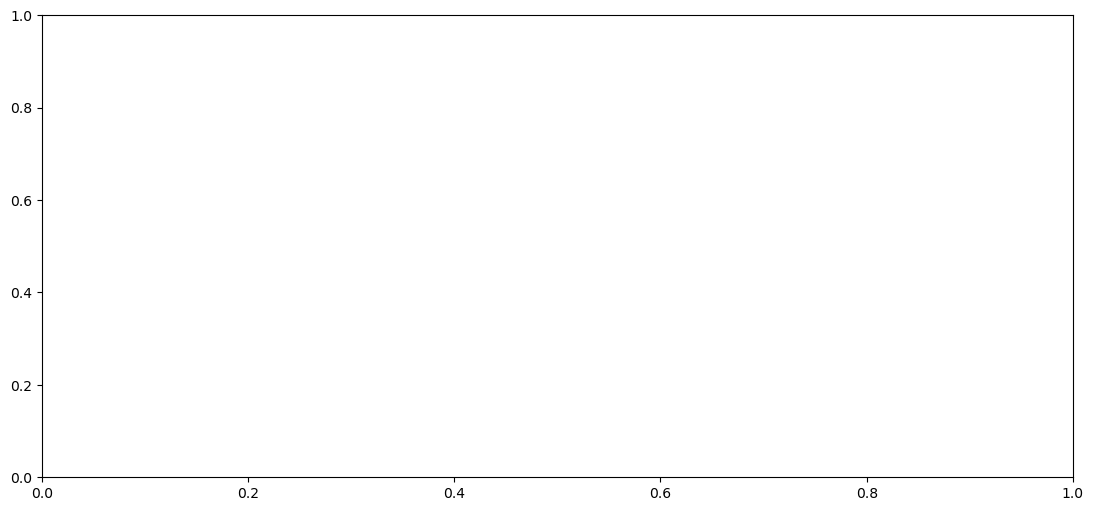

In [97]:
streamfunction.plot_depth_stf_vs_time(ds_out,'Total', 'psi_moc')

In [38]:
PSI_26 = xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_26.5N.nc"))
PSI_30 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_30S.nc"))
PSI_30_0 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_30S_section_0.nc"))
PSI_30_1 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_30S_section_1.nc"))
PSI_30_2 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_30S_section_2.nc"))
PSI_60 = xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_60S.nc"))
PSI_55 = xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_55S.nc"))

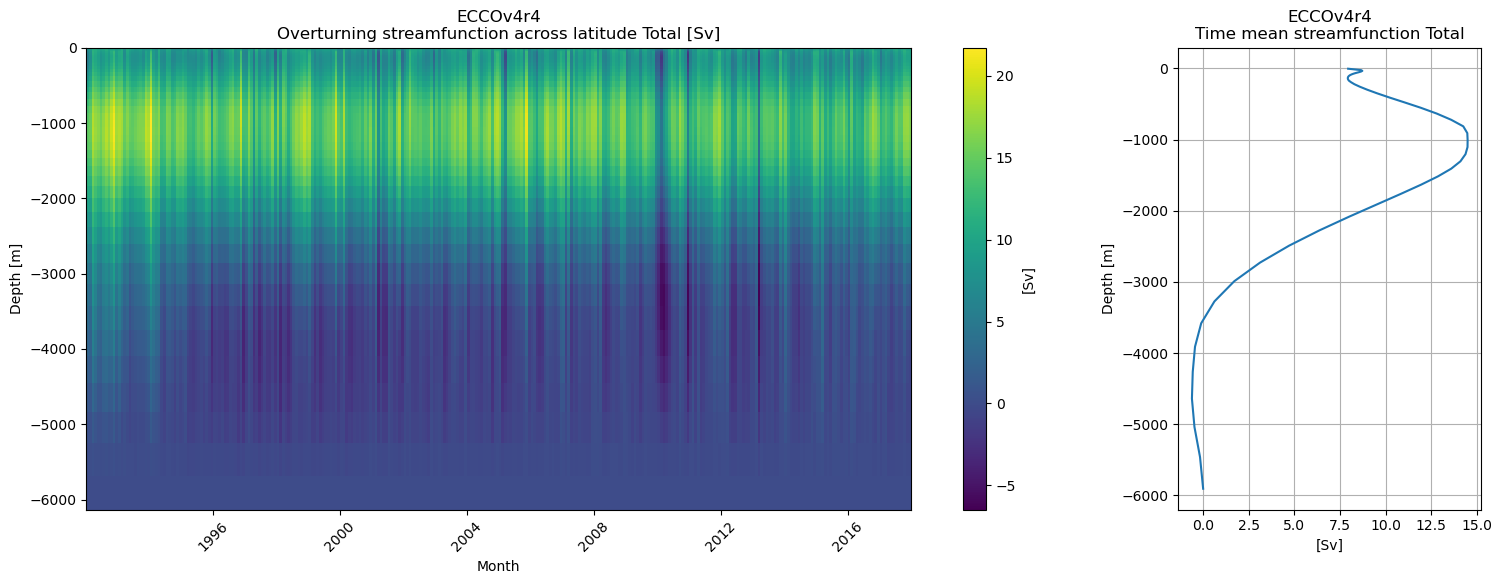

In [12]:
streamfunction.plot_depth_stf_vs_time(PSI_26,'Total', 'psi_moc')

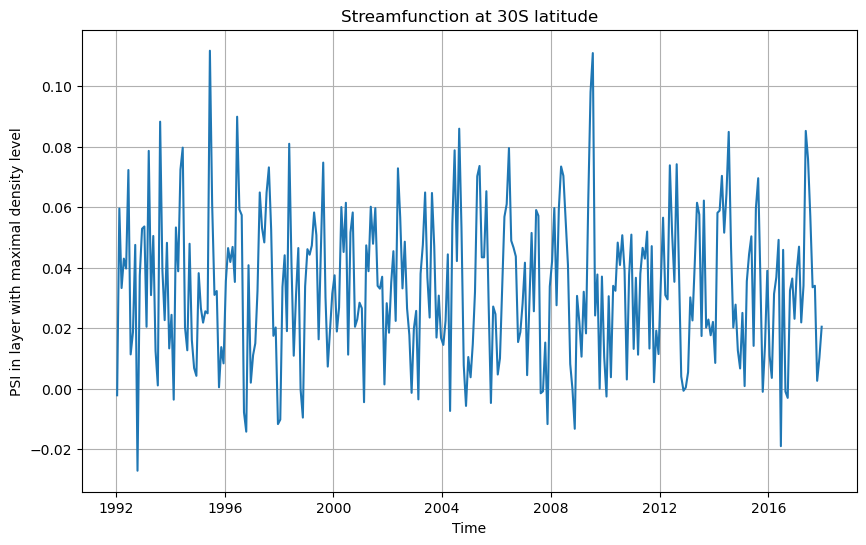

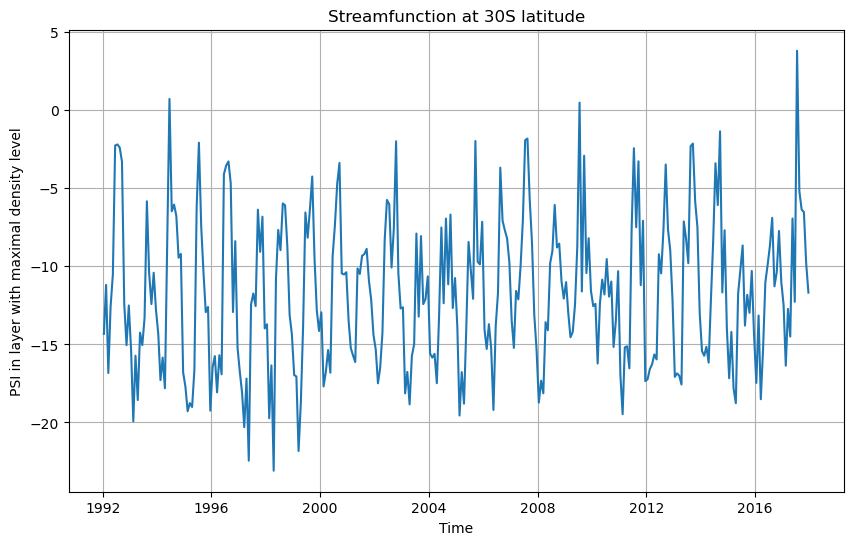

In [23]:
PSI_MAX_DENS = streamfunction.get_PSI_at_max_density_level(PSI_26, max=True)
streamfunction.plot_2D_streamfunction(PSI_MAX_DENS, f"Streamfunction at {format_lat_lon(latitude)} latitude")